In [63]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [64]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)

Using device: cuda


In [65]:
CHANNELS = 3
IMG_SIZE = 32
BATCH_SIZE = 32
MEAN = [0.5, 0.5, 0.5]
STD = [0.5, 0.5, 0.5]

In [99]:
data_dir = "trafic_32"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [67]:
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [68]:
len(full_dataset.classes)

43

### Diffusion model

In [69]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return x*(1 - amount) + noise*amount

In [70]:
class BasicUNet(nn.Module):
    def __init__(self, time_emb_dim=1):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.down_layers = nn.ModuleList([
            nn.Conv2d(CHANNELS, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = nn.ModuleList([
            nn.Conv2d(64 + time_emb_dim, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, CHANNELS, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x, t):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:
                h.append(x)
                x = self.downscale(x)

        t = t.view(t.size(0), self.time_emb_dim, 1, 1)
        t = t.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, t], dim=1)
        for i, l in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x += h.pop()
            x = self.act(l(x))

        return x

In [79]:
import math, torch
import torch.nn as nn
import torch.nn.functional as F

# 1) Add this above your class
def get_timestep_embedding(timesteps, dim):
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(half, device=timesteps.device) / half)
    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([args.sin(), args.cos()], dim=-1)
    return emb

class ImprovedBasicUNet(nn.Module):
    def __init__(self, time_emb_dim=64):
        super().__init__()
        self.time_emb_dim = time_emb_dim

        # 2) A small MLP to project the sinusoidal embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim*2),
            nn.SiLU(),
            nn.Linear(time_emb_dim*2, time_emb_dim),
        )

        # 3) Expand channels and add GroupNorm + residual
        self.down_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(3,  64, kernel_size=5, padding=2),
                nn.GroupNorm(8, 64),
                nn.SiLU(),
            ),
            nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),  # strided down
                nn.GroupNorm(8, 128),
                nn.SiLU(),
            ),
            nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=5, stride=2, padding=2),
                nn.GroupNorm(8, 128),
                nn.SiLU(),
            )
        ])

        # 4) Up blocks now take time_emb + skip, so in_ch = prev + time + skip
        self.up_layers = nn.ModuleList([
            nn.Sequential(
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.Conv2d(128 + time_emb_dim, 128, kernel_size=5, padding=2),
                nn.GroupNorm(8, 128),
                nn.SiLU(),
            ),
            nn.Sequential(
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.Conv2d(128 + time_emb_dim, 64, kernel_size=5, padding=2),
                nn.GroupNorm(8, 64),
                nn.SiLU(),
            ),
            nn.Conv2d(64 + time_emb_dim, 3, kernel_size=5, padding=2)  # final RGB
        ])

    def forward(self, x, t):
        # Embed time
        t_emb = get_timestep_embedding(t, self.time_emb_dim)
        t_emb = self.time_mlp(t_emb)

        skips = []
        # Down path
        for layer in self.down_layers:
            x = layer(x)
            skips.append(x)
        # Grab last feature (no further downsample)
        x_mid = skips.pop()  

        # Up path
        for layer in self.up_layers:
            # broadcast time and concat
            B, C, H, W = x_mid.shape
            temb = t_emb.view(B, self.time_emb_dim, 1, 1).expand(-1, -1, H, W)
            x_mid = torch.cat([x_mid, temb], dim=1)

            # apply the up-block
            x_mid = layer(x_mid)

            # add skip residual
            if skips:
                skip = skips.pop()
                x_mid = x_mid + skip

        return x_mid


In [71]:
net = BasicUNet().to(device)
net

BasicUNet(
  (down_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (up_layers): ModuleList(
    (0): Conv2d(65, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (act): SiLU()
  (downscale): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upscale): Upsample(scale_factor=2.0, mode='nearest')
)

In [96]:
net = ImprovedBasicUNet(time_emb_dim=256).to(device)

In [97]:
n_epochs = 10

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)


In [98]:
losses = []

for epoch in range(n_epochs):

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x, noise_amount)

        loss = loss_fn(pred, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_loader):])/len(train_loader)
    print(f"Finished epoch {epoch}, Avg epoch loss: {avg_loss:.5f}")

Finished epoch 0, Avg epoch loss: 0.03153
Finished epoch 1, Avg epoch loss: 0.01817
Finished epoch 2, Avg epoch loss: 0.01561
Finished epoch 3, Avg epoch loss: 0.01531
Finished epoch 4, Avg epoch loss: 0.01382
Finished epoch 5, Avg epoch loss: 0.01337
Finished epoch 6, Avg epoch loss: 0.43098
Finished epoch 7, Avg epoch loss: 0.02935
Finished epoch 8, Avg epoch loss: 0.02804
Finished epoch 9, Avg epoch loss: 0.02619


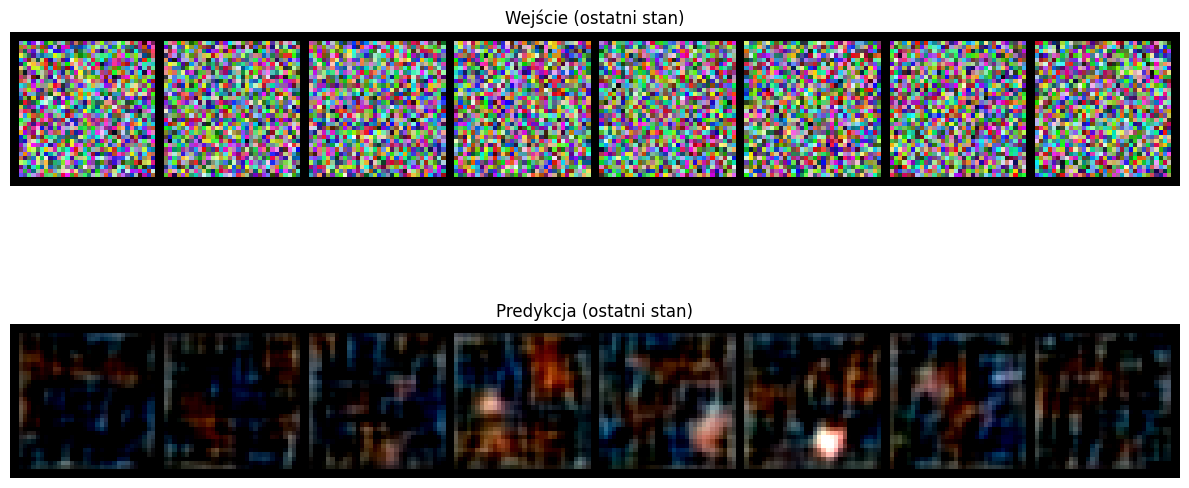

In [101]:
n_steps = 5
x = torch.rand(8, 3, 32, 32).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

import torchvision.utils as vutils

for i in range(n_steps):
    t = (torch.zeros(x.size(0)) + (n_steps - i)/n_steps).to(device)
    with torch.no_grad():
        pred = net(x, t) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    #---------- Uzupełnij proces generowania
    mix_factor = 1/(n_steps-i)
    x = x*(1-mix_factor) + pred*mix_factor
    #---------------------------------------


    step_history.append(x.detach().cpu()) # Store step for plotting




# x_last = vutils.make_grid(step_history[0], normalize=True)
# p_last = vutils.make_grid(pred_output_history[-1], normalize=True)

x_last = vutils.make_grid(step_history[0])
p_last = vutils.make_grid(pred_output_history[-1])

# zamień C×H×W → H×W×C i na numpy
x_img = x_last.permute(1, 2, 0).cpu().numpy().clip(0, 1)
p_img = p_last.permute(1, 2, 0).cpu().numpy().clip(0, 1)

# rysowanie
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
axes[0].set_title('Wejście (ostatni stan)')
axes[1].set_title('Predykcja (ostatni stan)')

axes[0].imshow(x_img)
axes[1].imshow(p_img)

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

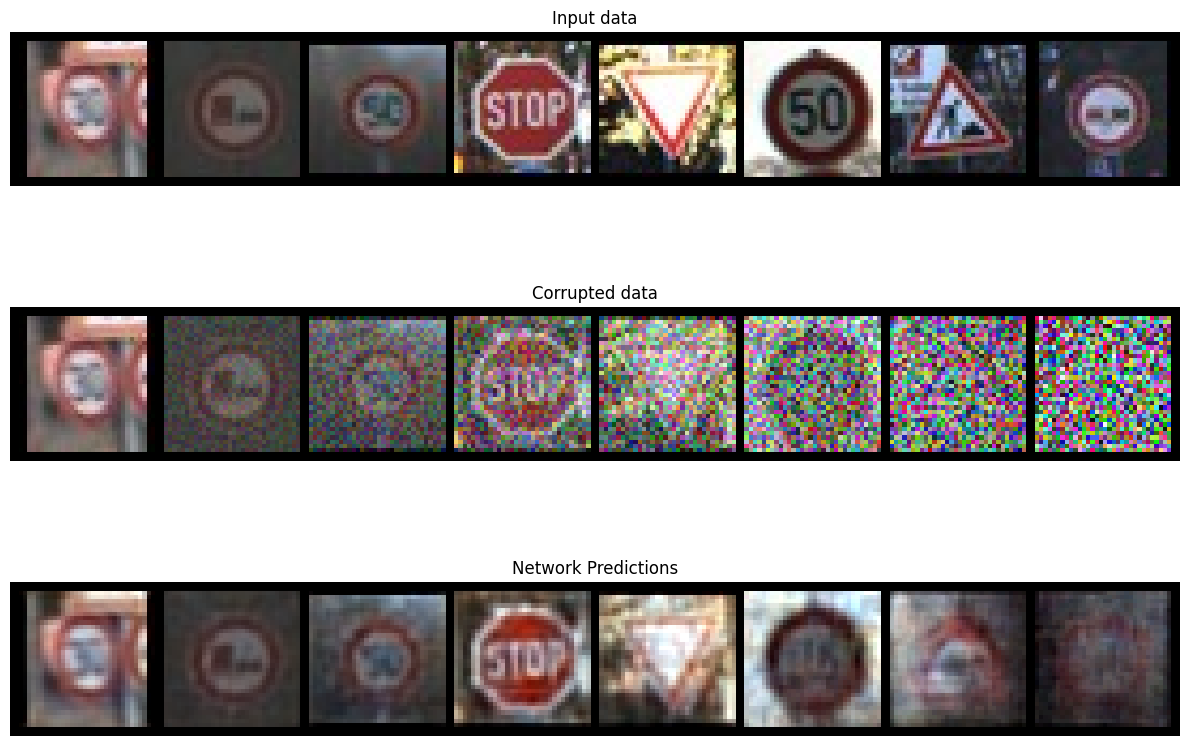

In [75]:
x, y = next(iter(val_loader))
x = x[:8]

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

with torch.no_grad():
    preds = net(noised_x.to(device), amount.to(device)).detach().cpu()
 
def show_batch(title, imgs, ax):
    # imgs: Tensor of shape (B, C, H, W)
    grid = torchvision.utils.make_grid(imgs, nrow=imgs.size(0))  # -> (C, H, W)
    grid = grid.permute(1, 2, 0).clip(0, 1).cpu().numpy()          # -> (H, W, C)
    ax.imshow(grid)
    ax.set_title(title)
    ax.axis('off')

fig, axs = plt.subplots(3, 1, figsize=(12, 9))

show_batch("Input data",        x,        axs[0])
show_batch("Corrupted data",    noised_x, axs[1])
show_batch("Network Predictions", preds,  axs[2])

plt.tight_layout()
plt.show()